In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset,random_split
# from torchvision import datasets, transforms
import pickle
import numpy as np
import joblib
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
# from imblearn.under_sampling import NearMiss
from sklearn.preprocessing import StandardScaler
# from imblearn.over_sampling import ADASYN,KMeansSMOTE,BorderlineSMOTE,SMOTE,SVMSMOTE
import sys
# from imblearn.combine import SMOTETomek
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score,confusion_matrix
import ast
import pandas as pd
from scipy.stats import wilcoxon,ttest_rel
import copy
import matplotlib.patches as mpatches
import random

/data8t/haominsheng/conda/anaconda3/envs/py38new/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.is_available()

True

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
torch.manual_seed(52)

### 读取数据

In [ ]:
# 后续数据有更新，将部分文件替换为带_20240318后缀的

In [4]:
walk_result=pd.read_pickle('./11.29_data_comb/walk_results_drug_7940.pkl')

In [5]:
drug_combination = pd.read_csv('./drug_combination.csv')
# with open('./11.29_data_comb/walk_results_drug_7940.pkl','rb') as f:
#     walk_result = pickle.load(f)
with open('./11.29_data_comb/drug_list_all.pkl','rb') as f:
    drug_list = pickle.load(f)
with open('./11.29_data_comb/diseases_df_all.pkl','rb') as f:
    disease_df = pickle.load(f)
mesh_info = pd.read_csv('./11.29_data_comb/mesh_info.csv')

In [6]:
# 104个组合结果
comb_pos_test=torch.load('./11.29_data_comb/new_combination_pos_test.pkl')

In [7]:
# 301个组合结果
comb_pos_all=torch.load('./11.29_data_comb/new_combination_pos_all.pkl')

In [8]:
# 301个组合的list，每个list对应每个组合的几个药物单独拼起来
comb_single=pickle.load(open('./11.29_data_comb/comb_single.pkl','rb'))

In [9]:
pair_in_d_g_idx=np.where(drug_combination['each_singledrug_diease_pair_in_d_g']==True)

In [10]:
# 提取出104个组合药物里的单一药物组合列表
comb_single_in_d_g=[comb_single[x] for x in pair_in_d_g_idx[0]]

In [11]:
# 读取已经被随机替换掉一个药物的104个组合药物
comb_pos_test_with_one_random=torch.load('./11.29_data_comb/new_combination_pos_test_with_random_one_random.pkl')

In [12]:
# 读取已经被随机替换掉一个药物的301个组合药物，是新批次生成的，因为有随机替换所以和104个随机替换的还不能一样，随机替换的药物不一样，301这个是设置了随机数种子
comb_with_one_random=torch.load('./11.29_data_comb/new_combination_with_random_one_random_301_new_batch.pkl')

In [13]:
scaler = pickle.load(open('./11.20_model/scaler_SMOTE.pkl','rb'))

/data8t/haominsheng/conda/anaconda3/envs/py38new/lib/python3.8/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [12]:
# 选出用于测试的31个组合和用于finetune的73个组合
np.random.seed(0)
finetune_test_idx=np.random.choice(range(104),31,replace=False).tolist()
finetune_train_idx=[]
for x in range(104):
    if x not in finetune_test_idx:
        finetune_train_idx.append(x)
# 31个作为测试
comb_pos_test_fortest=comb_pos_test[finetune_test_idx]
comb_single_in_d_g_fortest=[comb_single_in_d_g[x] for x in finetune_test_idx]
comb_pos_test_with_one_random_fortest=comb_pos_test_with_one_random[finetune_test_idx]
# # 全体作为测试
# comb_pos_test_fortest=comb_pos_test
# comb_single_in_d_g_fortest=comb_single_in_d_g
# comb_pos_test_with_one_random_fortest=comb_pos_test_with_one_random
# 训练集
comb_pos_test_forfinetune=comb_pos_test[finetune_train_idx]
comb_single_in_d_g_forfinetune=[comb_single_in_d_g[x] for x in finetune_train_idx]
comb_pos_test_with_one_random_forfinetune=comb_pos_test_with_one_random[finetune_train_idx]

In [14]:
comb_with_one_random.shape

torch.Size([301, 19277])

In [15]:
comb_pos_all.shape

torch.Size([301, 19277])

In [14]:
# 选出用于测试的76个组合和用于finetune的225个组合
np.random.seed(0)
finetune_test_idx=np.random.choice(range(301),76,replace=False).tolist()
finetune_train_idx=[]
for x in range(301):
    if x not in finetune_test_idx:
        finetune_train_idx.append(x)
# 76个作为测试集
comb_neg_test=comb_with_one_random[finetune_test_idx]
comb_pos_test=comb_pos_all[finetune_test_idx]
# 225个作为训练集
comb_neg_finetune=comb_with_one_random[finetune_train_idx]
comb_pos_finetune=comb_pos_all[finetune_train_idx]

### 进行测试

#### MLP

In [14]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.bn1 = nn.BatchNorm1d(hidden_size_1)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.bn2 = nn.BatchNorm1d(hidden_size_2)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(hidden_size_2, hidden_size_3)
        self.bn3 = nn.BatchNorm1d(hidden_size_3)
        self.dropout3 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(hidden_size_3, hidden_size_4)
        self.bn4 = nn.BatchNorm1d(hidden_size_4)
        self.dropout4 = nn.Dropout(0.5)
        self.fc5 = nn.Linear(hidden_size_4, num_classes)

    def forward(self, x):
        x = self.dropout1(F.leaky_relu(self.bn1(self.fc1(x))))
        x = self.dropout2(F.leaky_relu(self.bn2(self.fc2(x))))
        x = self.dropout3(F.leaky_relu(self.bn3(self.fc3(x))))
        x = self.dropout4(F.leaky_relu(self.bn4(self.fc4(x))))
        x = self.fc5(x)
        return x

torch.manual_seed(52)
# 设定超参数
input_size = comb_pos_test_fortest.shape[1]  # 对于MNIST数据集
hidden_size_1 = 4096
hidden_size_2 = 1024
hidden_size_3 = 256
hidden_size_4 = 64
num_classes = 1
num_epochs = 30
batch_size = 32768*1
learning_rate = 0.001

model = SimpleNN(input_size, hidden_size_1,hidden_size_2, hidden_size_3, hidden_size_4, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.load_state_dict(torch.load(f'./11.20_model/SMOTE/model_epoch_25.pt'))

<All keys matched successfully>

In [15]:
# 对组合药物进行测试
model.eval()
with torch.no_grad():
    test_comb_outputs_mlp=model(torch.tensor(scaler.transform(np.array(comb_pos_test_fortest))).to(device))
test_comb_outputs_mlp=np.array([x[0] for x in np.array(test_comb_outputs_mlp.cpu())])

In [16]:
# 对每个组合的单一药物进行测试
test_comb_single_outputs_mlp=[]
for x in comb_single_in_d_g_fortest:
    temp=[]
    for y in x:
        model.eval()
        with torch.no_grad():
            outputs=model(torch.tensor(scaler.transform(np.array(torch.tensor(y).unsqueeze(dim=0)))).to(device))
            outputs=outputs.cpu().squeeze().item()
            temp.append(outputs)
    test_comb_single_outputs_mlp.append(temp)

In [17]:
# 取单一药物测试平均值
test_comb_single_outputs_mlp_mean=np.array([np.mean(x) for x in test_comb_single_outputs_mlp])

In [18]:
# 执行配对 Wilcoxon 符号秩检验
statistic, p_value = wilcoxon(test_comb_single_outputs_mlp_mean, test_comb_outputs_mlp,alternative='less')
# 输出检验结果
print('Wilcoxon 符号秩检验统计值:', statistic)
print('p 值:', p_value)

Wilcoxon 符号秩检验统计值: 915.0
p 值: 1.9816397586748554e-09


In [19]:
sum(test_comb_outputs_mlp>test_comb_single_outputs_mlp_mean)

81

In [20]:
# 对替换后的样本进行测试
model.eval()
with torch.no_grad():
    comb_replace_outputs_mlp=model(torch.tensor(scaler.transform(np.array(comb_pos_test_with_one_random_fortest))).to(device))
# 替换后的结果
comb_replace_outputs_mlp=np.array([x[0] for x in np.array(comb_replace_outputs_mlp.cpu())])

In [21]:
# 执行配对 Wilcoxon 符号秩检验
statistic, p_value = wilcoxon(comb_replace_outputs_mlp, test_comb_outputs_mlp,alternative='less')
# 输出检验结果
print('Wilcoxon 符号秩检验统计值:', statistic)
print('p 值:', p_value)

Wilcoxon 符号秩检验统计值: 281.0
p 值: 9.976638133042224e-16


In [22]:
# 这个应该是随即替换最后一个药物的情况
# # 执行配对 Wilcoxon 符号秩检验
# statistic, p_value = wilcoxon(comb_replace_outputs_mlp, test_comb_outputs_mlp,alternative='less')
# # 输出检验结果
# print('Wilcoxon 符号秩检验统计值:', statistic)
# print('p 值:', p_value)

In [23]:
sum(comb_replace_outputs_mlp<test_comb_outputs_mlp)

93

#### RF

In [24]:
from sklearn.ensemble import RandomForestClassifier
# 随机森林分类器
rf_classifier = RandomForestClassifier()
rf_classifier=pickle.load(open('./11.20_model/random_forest_model.pkl', 'rb'))

/data8t/haominsheng/conda/anaconda3/envs/py38new/lib/python3.8/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/data8t/haominsheng/conda/anaconda3/envs/py38new/lib/python3.8/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [25]:
# 对组合药物进行测试
test_comb_outputs_rf = rf_classifier.predict_proba(scaler.transform(np.array(comb_pos_test_fortest)))[:, 1]

In [26]:
# 对每个组合的单一药物进行测试
test_comb_single_outputs_rf=[]
for x in comb_single_in_d_g_fortest:
    temp=[]
    for y in x:
        outputs=rf_classifier.predict_proba(scaler.transform(np.array(torch.tensor(y).unsqueeze(dim=0))))[:, 1][0]
        temp.append(outputs)
    test_comb_single_outputs_rf.append(temp)

In [27]:
# 取单一药物测试平均值
test_comb_single_outputs_rf_mean=np.array([np.mean(x) for x in test_comb_single_outputs_rf])

In [28]:
# 执行配对 Wilcoxon 符号秩检验
statistic, p_value = wilcoxon(test_comb_single_outputs_rf_mean, test_comb_outputs_rf,alternative='less')
# 输出检验结果
print('Wilcoxon 符号秩检验统计值:', statistic)
print('p 值:', p_value)

Wilcoxon 符号秩检验统计值: 4966.0
p 值: 0.9999999999997934


In [29]:
sum(test_comb_outputs_rf>test_comb_single_outputs_rf_mean)

16

In [30]:
# 对替换后的样本进行测试
comb_replace_outputs_rf=rf_classifier.predict_proba(scaler.transform(np.array(comb_pos_test_with_one_random_fortest)))[:, 1]

In [31]:
# 执行配对 Wilcoxon 符号秩检验
statistic, p_value = wilcoxon(comb_replace_outputs_rf, test_comb_outputs_rf,alternative='less')
# 输出检验结果
print('Wilcoxon 符号秩检验统计值:', statistic)
print('p 值:', p_value)

Wilcoxon 符号秩检验统计值: 537.5
p 值: 1.0968645871696303e-11


In [32]:
# 这个应该是随即替换最后一个药物的情况
# # 执行配对 Wilcoxon 符号秩检验
# statistic, p_value = wilcoxon(comb_replace_outputs_rf, test_comb_outputs_rf,alternative='less')
# # 输出检验结果
# print('Wilcoxon 符号秩检验统计值:', statistic)
# print('p 值:', p_value)

In [33]:
sum(comb_replace_outputs_rf<test_comb_outputs_rf)

75

#### LR

In [34]:
from sklearn.linear_model import LogisticRegression
# 逻辑回归分类器
logistic_classifier = LogisticRegression()
logistic_classifier=pickle.load(open('./11.20_model/logistic_regression_model.pkl', 'rb'))

In [35]:
# 对组合药物进行测试
test_comb_outputs_lr = logistic_classifier.predict_proba(scaler.transform(np.array(comb_pos_test_fortest)))[:, 1]

In [36]:
# 对每个组合的单一药物进行测试
test_comb_single_outputs_lr=[]
for x in comb_single_in_d_g_fortest:
    temp=[]
    for y in x:
        outputs=logistic_classifier.predict_proba(scaler.transform(np.array(torch.tensor(y).unsqueeze(dim=0))))[:, 1][0]
        temp.append(outputs)
    test_comb_single_outputs_lr.append(temp)

In [37]:
# 取单一药物测试平均值
test_comb_single_outputs_lr_mean=np.array([np.mean(x) for x in test_comb_single_outputs_lr])

In [38]:
# 执行配对 Wilcoxon 符号秩检验
statistic, p_value = wilcoxon(test_comb_single_outputs_lr_mean, test_comb_outputs_lr,alternative='less')
# 输出检验结果
print('Wilcoxon 符号秩检验统计值:', statistic)
print('p 值:', p_value)

Wilcoxon 符号秩检验统计值: 307.0
p 值: 1.961674260132862e-15


In [39]:
sum(test_comb_outputs_lr>test_comb_single_outputs_lr_mean)

99

In [40]:
# 对替换后的样本进行测试
comb_replace_outputs_lr=logistic_classifier.predict_proba(scaler.transform(np.array(comb_pos_test_with_one_random_fortest)))[:, 1]

In [41]:
# 执行配对 Wilcoxon 符号秩检验
statistic, p_value = wilcoxon(comb_replace_outputs_lr, test_comb_outputs_lr,alternative='less')
# 输出检验结果
print('Wilcoxon 符号秩检验统计值:', statistic)
print('p 值:', p_value)

Wilcoxon 符号秩检验统计值: 132.0
p 值: 1.806623649172086e-17


In [42]:
# # 这个应该是随即替换最后一个药物的情况
# # 执行配对 Wilcoxon 符号秩检验
# statistic, p_value = wilcoxon(comb_replace_outputs_lr, test_comb_outputs_lr,alternative='less')
# # 输出检验结果
# print('Wilcoxon 符号秩检验统计值:', statistic)
# print('p 值:', p_value)

In [43]:
sum(comb_replace_outputs_lr<test_comb_outputs_lr)

98

### 对比分析

In [44]:
import matplotlib.pyplot as plt 
from matplotlib import font_manager 
 
# download the font files and save in this fold
font_path = "./font"
 
font_files = font_manager.findSystemFonts(fontpaths=font_path)
 
for file in font_files:
    font_manager.fontManager.addfont(file)

In [45]:
plt.rcParams["font.family"] = "Arial"

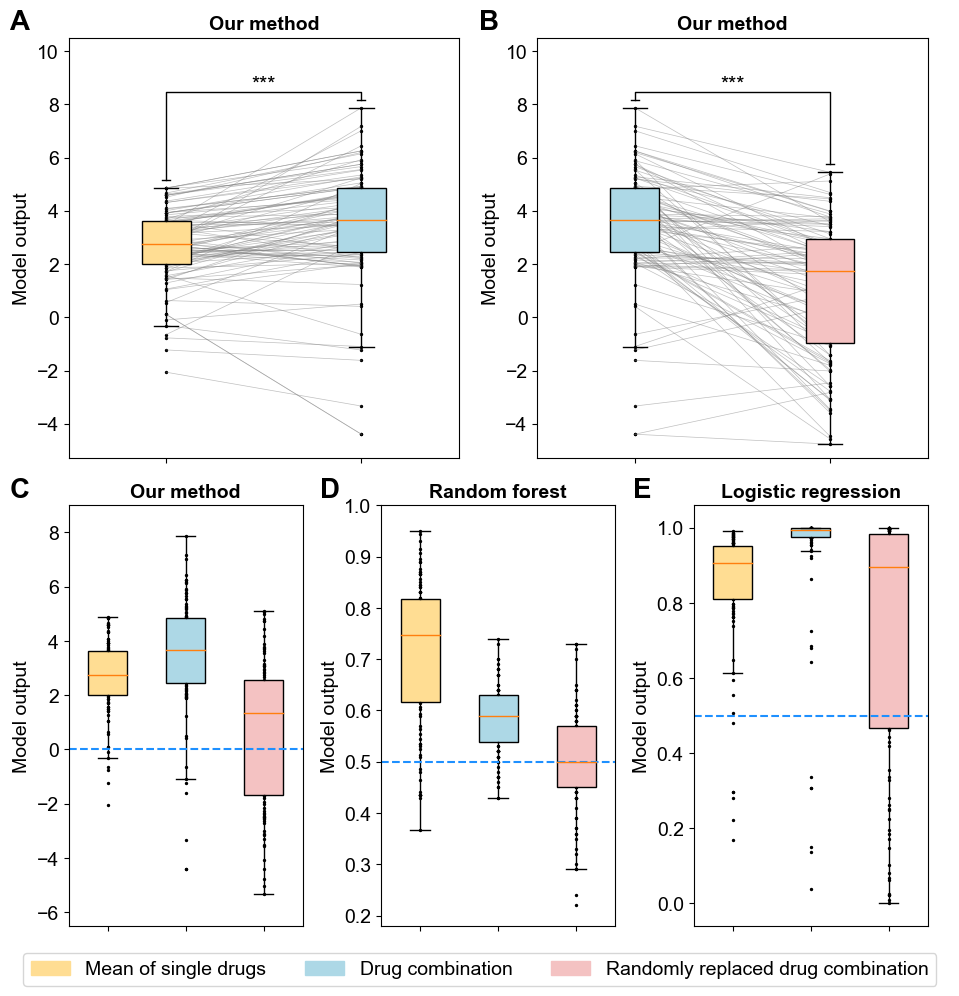

In [131]:
def save_pkl(obj,path):
    with open(path,'wb') as f:
        pickle.dump(obj,f)

def read_pkl(path):
    with open(path,'rb') as f:
        obj=pickle.load(f)
    return obj

a=read_pkl('pics/comb_single2.pkl')
test_comb_single_outputs_mean=a[0]
test_comb_outputs=a[1]

a=read_pkl('pics/comb_replace2.pkl')
comb_replace_outputs=a[0]
test_comb_outputs=a[1]

# 合并俩图
# 第一个图
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((2, 6), (0, 0), colspan=3)
for x in range(test_comb_single_outputs_mean.shape[0]):
    plt.scatter(1,test_comb_single_outputs_mean[x],c='black',s=2)
    plt.scatter(2,test_comb_outputs[x],c='black',s=2)
    plt.plot([1,2],[test_comb_single_outputs_mean[x],test_comb_outputs[x]],c='gray',lw=0.5,alpha=0.5)
box=plt.boxplot([test_comb_single_outputs_mean, test_comb_outputs],labels=['Mean of single drugs','Drug combination'],patch_artist=True,showfliers=False,widths=0.25)
plt.xticks([1, 2], ['']*2)
# 设置箱体颜色
colors = ['#ffdd93', '#add8e6']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
# 添加显著性检验的连线和标记
x1, x2 = 1, 2  # 箱线图的位置
y1=np.max(test_comb_single_outputs_mean)+0.3
y2=np.max(test_comb_outputs)+0.3
plt.plot([x1-0.02, x1+0.02], [y1,y1], lw=1, c='black')
plt.plot([x2-0.02, x2+0.02], [y2,y2], lw=1, c='black')
plt.plot([x1, x1, x2, x2], [y1, max(y1,y2)+0.3, max(y1,y2)+0.3, y2], lw=1, c='black')
plt.text((x1+x2)*.5, max(y1,y2)+0.2, "***", ha='center', va='bottom', color='black',fontsize=15)

plt.ylim(-5.3,10.5)
plt.ylabel('Model output',fontsize=14)
plt.title('Our method',fontsize=14, fontweight='bold')
# Increase font size of labels
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.text(-0.15, 1.02, "A", transform=plt.gca().transAxes, fontsize=20, fontweight='bold', color='black')

# 第二个图
ax1 = plt.subplot2grid((2, 6), (0, 3), colspan=3)
for x in range(comb_replace_outputs.shape[0]):
    plt.scatter(2,comb_replace_outputs[x],c='black',s=2)
    plt.scatter(1,test_comb_outputs[x],c='black',s=2)
    plt.plot([2,1],[comb_replace_outputs[x],test_comb_outputs[x]],c='gray',lw=0.5,alpha=0.5)
box=plt.boxplot([test_comb_outputs,comb_replace_outputs],labels=['Drug combination','Randomly replaced\ndrug combination'],patch_artist=True,showfliers=False,widths=0.25)
plt.xticks([1, 2], ['']*2)
# 设置箱体颜色
colors = ['#add8e6','#f4c2c2']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
# 添加显著性检验的连线和标记
x1, x2 = 1, 2  # 箱线图的位置
y1=np.max(test_comb_outputs)+0.3
y2=np.max(comb_replace_outputs)+0.3
plt.plot([x1-0.02, x1+0.02], [y1,y1], lw=1, c='black')
plt.plot([x2-0.02, x2+0.02], [y2,y2], lw=1, c='black')
plt.plot([x1, x1, x2, x2], [y1, max(y1,y2)+0.3, max(y1,y2)+0.3, y2], lw=1, c='black')
plt.text((x1+x2)*.5, max(y1,y2)+0.2, "***", ha='center', va='bottom', color='black',fontsize=15)
plt.ylabel('Model output',fontsize=14)
plt.ylim(-5.3,10.5)
plt.title('Our method',fontsize=14, fontweight='bold')
# Increase font size of labels
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.text(-0.15, 1.02, "B", transform=plt.gca().transAxes, fontsize=20, fontweight='bold', color='black')
# 合并仨图
ax1 = plt.subplot2grid((2, 6), (1, 0), colspan=2)
for x in range(test_comb_single_outputs_mlp_mean.shape[0]):
    plt.scatter(1,test_comb_single_outputs_mlp_mean[x],c='black',s=2)
    plt.scatter(2,test_comb_outputs_mlp[x],c='black',s=2)
    plt.scatter(3,comb_replace_outputs_mlp[x],c='black',s=2)
    # plt.plot([1,2],[test_comb_single_outputs_mlp_mean[x],test_comb_outputs_mlp[x]],c='gray',lw=0.5,alpha=0.5)
    # plt.plot([2,3],[test_comb_outputs_mlp[x],comb_replace_outputs_mlp[x]],c='gray',lw=0.5,alpha=0.5)
box=plt.boxplot([test_comb_single_outputs_mlp_mean, test_comb_outputs_mlp,comb_replace_outputs_mlp],labels=['Mean of single drugs','Drug combination','Randomly replaced\ndrug combination'],patch_artist=True, showfliers=False, widths=0.5)
plt.xticks([1, 2, 3], ['']*3)
# 设置箱体颜色
colors = ['#ffdd93', '#add8e6', '#f4c2c2']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.axhline(0,color='dodgerblue',linestyle='--')
plt.title('Our method',fontsize=14, fontweight='bold')
plt.ylim(-6.5,9)
plt.ylabel('Model output',fontsize=14)
plt.text(-0.25, 1.02, "C", transform=plt.gca().transAxes, fontsize=20, fontweight='bold', color='black')
# Increase font size of labels
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)


ax1 = plt.subplot2grid((2, 6), (1, 2), colspan=2)
for x in range(test_comb_single_outputs_rf_mean.shape[0]):
    plt.scatter(1,test_comb_single_outputs_rf_mean[x],c='black',s=2)
    plt.scatter(2,test_comb_outputs_rf[x],c='black',s=2)
    plt.scatter(3,comb_replace_outputs_rf[x],c='black',s=2)
    # plt.plot([1,2],[test_comb_single_outputs_rf_mean[x],test_comb_outputs_rf[x]],c='gray',lw=0.5,alpha=0.5)
    # plt.plot([2,3],[test_comb_outputs_rf[x],comb_replace_outputs_rf[x]],c='gray',lw=0.5,alpha=0.5)
box=plt.boxplot([test_comb_single_outputs_rf_mean, test_comb_outputs_rf,comb_replace_outputs_rf],labels=['Mean of single drugs','Drug combination','Randomly replaced\ndrug combination'],patch_artist=True,showfliers=False,widths=0.5)
plt.xticks([1, 2, 3], ['']*3)
# 设置箱体颜色
colors = ['#ffdd93', '#add8e6', '#f4c2c2']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.axhline(0.5,color='dodgerblue',linestyle='--')
plt.ylim(0.18,1.0)
plt.ylabel('Model output',fontsize=14)
plt.text(-0.26, 1.02, "D", transform=plt.gca().transAxes, fontsize=20, fontweight='bold', color='black')
plt.title('Random forest',fontsize=14, fontweight='bold')
# Increase font size of labels
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)


ax1 = plt.subplot2grid((2, 6), (1, 4), colspan=2)
for x in range(test_comb_single_outputs_lr_mean.shape[0]):
    plt.scatter(1,test_comb_single_outputs_lr_mean[x],c='black',s=2)
    plt.scatter(2,test_comb_outputs_lr[x],c='black',s=2)
    plt.scatter(3,comb_replace_outputs_lr[x],c='black',s=2)
    # plt.plot([1,2],[test_comb_single_outputs_lr_mean[x],test_comb_outputs_lr[x]],c='gray',lw=0.5,alpha=0.5)
    # plt.plot([2,3],[test_comb_outputs_lr[x],comb_replace_outputs_lr[x]],c='gray',lw=0.5,alpha=0.5)
box=plt.boxplot([test_comb_single_outputs_lr_mean, test_comb_outputs_lr,comb_replace_outputs_lr],labels=['Mean of single drugs','Drug combination','Randomly replaced\ndrug combination'],patch_artist=True,showfliers=False,widths=0.5)
plt.xticks([1, 2, 3], ['']*3)
# 设置箱体颜色
colors = ['#ffdd93', '#add8e6', '#f4c2c2']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.ylim(-0.06,1.06)
plt.axhline(0.5,color='dodgerblue',linestyle='--')
plt.ylabel('Model output',fontsize=14)
plt.text(-0.26, 1.02, "E", transform=plt.gca().transAxes, fontsize=20, fontweight='bold', color='black')
plt.title('Logistic regression',fontsize=14, fontweight='bold')
# Increase font size of labels
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)



# 创建色块图例
patches = [mpatches.Patch(color='#ffdd93', label='Mean of single drugs'),
           mpatches.Patch(color='#add8e6', label='Drug combination'),
           mpatches.Patch(color='#f4c2c2', label='Randomly replaced drug combination')]
# 添加图例
plt.figlegend(handles=patches, loc='lower center', ncol=3, labelspacing=2,fontsize=14)
plt.tight_layout(rect=[0, 0.05, 0.95, 1])  # 调整布局以留出空间放置图例
# plt.tight_layout()
# plt.subplots_adjust(wspace=0.28)  # 设置水平间距
plt.savefig('./pics/Figure_comb.png', dpi=300)
plt.show()


### finetune

In [22]:
# comb_pos_test_forfinetune_ori=copy.deepcopy(comb_pos_test_forfinetune)
# comb_single_in_d_g_forfinetune_ori=copy.deepcopy(comb_single_in_d_g_forfinetune)
comb_pos_test_with_one_random_forfinetune_ori=copy.deepcopy(comb_pos_test_with_one_random_forfinetune)

In [15]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.bn1 = nn.BatchNorm1d(hidden_size_1)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.bn2 = nn.BatchNorm1d(hidden_size_2)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(hidden_size_2, hidden_size_3)
        self.bn3 = nn.BatchNorm1d(hidden_size_3)
        self.dropout3 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(hidden_size_3, hidden_size_4)
        self.bn4 = nn.BatchNorm1d(hidden_size_4)
        self.dropout4 = nn.Dropout(0.5)
        self.fc5 = nn.Linear(hidden_size_4, num_classes)

    def forward(self, x):
        x = self.dropout1(F.leaky_relu(self.bn1(self.fc1(x))))
        x = self.dropout2(F.leaky_relu(self.bn2(self.fc2(x))))
        x = self.dropout3(F.leaky_relu(self.bn3(self.fc3(x))))
        x = self.dropout4(F.leaky_relu(self.bn4(self.fc4(x))))
        x = self.fc5(x)
        return x

torch.manual_seed(52)
# 设定超参数
input_size = 19277
hidden_size_1 = 4096
hidden_size_2 = 1024
hidden_size_3 = 256
hidden_size_4 = 64
num_classes = 1
num_epochs = 10
batch_size = 32768*1
learning_rate = 0.001

class CustomDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        if self.transform:
            x = self.transform(x)
        return x, y

In [185]:
# 变化finetune的epoch数，调整结构计算每个epoch的auc，【采用301个组合】
# 每次测试集固定
input_data_val=torch.vstack((comb_pos_test,comb_neg_test))
val_dataset_scaled = scaler.transform(np.array(input_data_val))
val_dataset = CustomDataset(data=val_dataset_scaled,targets=torch.tensor([1]*76+[0]*76),transform = None)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
def set_seed(seed):
    random.seed(seed)  # Python random module.
    np.random.seed(seed)  # Numpy module.
    os.environ['PYTHONHASHSEED'] = str(seed)  # Python的哈希随机化，影响字典和集合操作。
    
    torch.manual_seed(seed)  # CPU上的种子
    if torch.cuda.is_available():
        print('初始化gpu种子')
        torch.cuda.manual_seed(seed)  # 当前GPU的种子
        torch.cuda.manual_seed_all(seed)  # 所有GPU的种子
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

auc_list=[]
f1_list=[]
train_loss_big_list=[]
val_loss_big_list=[]
acc_list=[]
# for finetune_number in [75,150,225]:
for finetune_number in [225]:
    auc_list_temp=[]
    f1_list_temp=[]
    acc_list_temp=[]
    train_loss_big_list_temp=[]
    val_loss_big_list_temp=[]
    # 设置一个种子
    set_seed(52)
    for e in range(20):
        auc_list_temp_temp=[]
        acc_list_temp_temp=[]
        f1_list_temp_temp=[]
        train_loss_big_list_temp_temp=[]
        val_loss_big_list_temp_temp=[]
        # 每次随机打乱一下训练集的顺序
        finetune_train_idx=np.random.choice(range(225),finetune_number,replace=False)
        input_data_train=torch.vstack((comb_pos_finetune[finetune_train_idx],comb_neg_finetune[finetune_train_idx]))    
        train_dataset_scaled = scaler.transform(np.array(input_data_train))
        train_dataset = CustomDataset(data=train_dataset_scaled,targets=torch.tensor([1]*(finetune_number)+[0]*finetune_number),transform = None)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        # 加载模型
        model = SimpleNN(input_size, hidden_size_1,hidden_size_2, hidden_size_3, hidden_size_4, num_classes)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        model.load_state_dict(torch.load(f'./11.20_model/SMOTE/model_epoch_25.pt'))
        
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-3)
        for epoch in range(100):
            # Training
            model.train()
            correct = 0
            total = 0
            train_loss = 0.
        
            for i, (images, labels) in enumerate(train_loader):
                images = images.to(device)
                labels = labels.to(device)
                
                # Forward pass
                outputs = model(images.float())
                predicted = (outputs >= 0).float()
                total += labels.size(0)
                loss = criterion(outputs, labels.view(-1,1).float())
                train_loss += loss.item()
                correct += (predicted == labels.view(-1,1)).sum().item()
                
                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                # scheduler.step()
            
            train_accuracy = 100 * correct / total
            train_loss = train_loss / len(train_loader)
        
            # Validation
            model.eval()
            val_outputs=[]
            val_labels = []
            val_predictions=[]
            with torch.no_grad():
                correct = 0
                total = 0
                val_loss = 0.
                
                for i, (images, labels) in enumerate(val_loader):
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = model(images.float())
                    val_outputs.extend(outputs)
                    val_labels.extend(labels.cpu().numpy())
                    predicted = (outputs >= 0).float()
                    val_predictions.extend(predicted.cpu().numpy())
                    total += labels.size(0)
                    loss = criterion(outputs, labels.view(-1,1).float())
                    val_loss += loss.item()
                    correct += (predicted == labels.view(-1,1)).sum().item()
        
                val_accuracy = 100 * correct / total
                val_loss = val_loss / len(val_loader)
            val_outputs=torch.stack(val_outputs).to(device)
            val_probability=torch.sigmoid(val_outputs)
            val_probability=val_probability.cpu().squeeze().tolist()
            fpr, tpr, thresholds = roc_curve(val_labels, val_probability)
            roc_auc = auc(fpr, tpr)
            auc_list_temp_temp.append(roc_auc)
            acc_list_temp_temp.append(val_accuracy)
            f1 = f1_score(val_labels, val_predictions)
            f1_list_temp_temp.append(f1)
            train_loss_big_list_temp_temp.append(train_loss)
            val_loss_big_list_temp_temp.append(val_loss)
            precision = precision_score(val_labels, val_predictions)
            recall = recall_score(val_labels, val_predictions)
            tn, fp, fn, tp = confusion_matrix(val_labels, val_predictions).ravel()
            specificity = tn / (tn + fp)
            aupr = average_precision_score(val_labels, val_probability)
            output_checkpoint=f'finetune number {finetune_number}, e [{e+1}/{20}], Epoch [{epoch+1}/{100}], Train ACC: {train_accuracy:.2f}%, Val ACC: {val_accuracy:.2f}%, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}, AUC: {roc_auc:.2f}'
            print(output_checkpoint)
            # if finetune_number==225 and e==1 and epoch==47:
            #     torch.save(model.state_dict(), f'./11.20_model/finetune_new/model_finetune_{finetune_number}_e_{e}_epoch_{epoch}.pt')
            if roc_auc>auc_ori and aupr>aupr_ori and val_accuracy>acc_ori and f1>f1_ori and precision>precision_ori and recall+0.025>recall_ori and specificity>specificity_ori and epoch<50:
                torch.save(model.state_dict(), f'./11.20_model/finetune_new/model_finetune_{finetune_number}_e_{e}_epoch_{epoch}.pt')
            with open('./11.20_model/finetune/checkpoints.txt', 'a') as file:
                original_stdout = sys.stdout 
                sys.stdout = file 
                print(output_checkpoint)
                sys.stdout = original_stdout
        auc_list_temp.append(auc_list_temp_temp)
        acc_list_temp.append(acc_list_temp_temp)
        f1_list_temp.append(f1_list_temp_temp)
        train_loss_big_list_temp.append(train_loss_big_list_temp_temp)
        val_loss_big_list_temp.append(val_loss_big_list_temp_temp)
        
    auc_list.append(auc_list_temp)
    acc_list.append(acc_list_temp)
    f1_list.append(f1_list_temp)
    train_loss_big_list.append(train_loss_big_list_temp)
    val_loss_big_list.append(val_loss_big_list_temp)
auc_list=np.array(auc_list)
acc_list=np.array(acc_list)
f1_list=np.array(f1_list)
train_loss_big_list=np.array(train_loss_big_list)
val_loss_big_list=np.array(val_loss_big_list)

print('auc best model: '+best_model_auc)
print('f1 best model: '+best_model_f1)
print(f'max auc {max_aucc}')
print(f'max f1 {max_f1}')

初始化gpu种子
finetune number 225, e [1/20], Epoch [1/100], Train ACC: 70.44%, Val ACC: 59.21%, Train Loss: 0.9762, Val Loss: 1.4375, Precision: 0.68, Recall: 0.36, F1: 0.47, AUC: 0.65
finetune number 225, e [1/20], Epoch [2/100], Train ACC: 70.89%, Val ACC: 63.82%, Train Loss: 0.8818, Val Loss: 1.1674, Precision: 0.73, Recall: 0.43, F1: 0.55, AUC: 0.70
finetune number 225, e [1/20], Epoch [3/100], Train ACC: 75.78%, Val ACC: 63.82%, Train Loss: 0.6056, Val Loss: 1.0000, Precision: 0.76, Recall: 0.41, F1: 0.53, AUC: 0.74
finetune number 225, e [1/20], Epoch [4/100], Train ACC: 85.33%, Val ACC: 63.82%, Train Loss: 0.3761, Val Loss: 0.8903, Precision: 0.67, Recall: 0.54, F1: 0.60, AUC: 0.72
finetune number 225, e [1/20], Epoch [5/100], Train ACC: 82.00%, Val ACC: 69.74%, Train Loss: 0.3390, Val Loss: 0.8810, Precision: 0.65, Recall: 0.84, F1: 0.74, AUC: 0.75
finetune number 225, e [1/20], Epoch [6/100], Train ACC: 92.22%, Val ACC: 67.11%, Train Loss: 0.2150, Val Loss: 0.9947, Precision: 0.62,

In [131]:
# 不finetune的情况
# 加载模型
model = SimpleNN(input_size, hidden_size_1,hidden_size_2, hidden_size_3, hidden_size_4, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.load_state_dict(torch.load(f'./11.20_model/SMOTE/model_epoch_25.pt'))
# Validation
model.eval()
val_outputs=[]
val_labels = []
val_predictions=[]
with torch.no_grad():
    correct = 0
    total = 0
    val_loss = 0.
    
    for i, (images, labels) in enumerate(val_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images.float())
        val_outputs.extend(outputs)
        val_labels.extend(labels.cpu().numpy())
        predicted = (outputs >= 0).float()
        val_predictions.extend(predicted.cpu().numpy())
        total += labels.size(0)
        loss = criterion(outputs, labels.view(-1,1).float())
        val_loss += loss.item()
        correct += (predicted == labels.view(-1,1)).sum().item()

    val_accuracy = 100 * correct / total
    val_loss = val_loss / len(val_loader)
val_outputs=torch.stack(val_outputs).to(device)
val_probability=torch.sigmoid(val_outputs)
val_probability=val_probability.cpu().squeeze().tolist()
fpr, tpr, thresholds = roc_curve(val_labels, val_probability)
roc_auc = auc(fpr, tpr)
f1 = f1_score(val_labels, val_predictions)
precision = precision_score(val_labels, val_predictions)
recall = recall_score(val_labels, val_predictions)
tn, fp, fn, tp = confusion_matrix(val_labels, val_predictions).ravel()
specificity = tn / (tn + fp)
aupr = average_precision_score(val_labels, val_probability)
print(f'''auc:{roc_auc}
f1:{f1}
precision:{precision}
recall:{recall}
specificity:{specificity}
acc:{val_accuracy}
aupr:{aupr}''')

auc:0.7605609418282548
f1:0.7120418848167539
precision:0.591304347826087
recall:0.8947368421052632
specificity:0.3815789473684211
acc:63.81578947368421
aupr:0.7686401359111881
